In [66]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

In [15]:
image_df = pd.DataFrame({'Filepath':[],'Label':[]})

In [29]:
labels = []
paths=[]
folder_path = "./dataset/Vehicle_5_classes_sample"
if os.path.exists(folder_path):
    # Get a list of all files in the folder
    folders = os.listdir(folder_path)
    
    for folder in folders:
        paths.extend(os.listdir(folder_path+"/"+folder))
        labels.extend(list( folder for i in range(len(os.listdir(folder_path+"/"+folder)))))
else:
    print("Folder does not exist.")


Files in the folder:


In [46]:
image_df['Filepath']= paths
image_df['Label']=labels

In [47]:
image_df['Filepath'] = folder_path+"/"+image_df['Label']+"/"+image_df['Filepath']

In [48]:
image_df

,Filepath,Label
0,./dataset/Vehicle_5_classes_sample/Auto/Datacl...,Auto
1,./dataset/Vehicle_5_classes_sample/Auto/Datacl...,Auto
2,./dataset/Vehicle_5_classes_sample/Auto/Datacl...,Auto
3,./dataset/Vehicle_5_classes_sample/Auto/Datacl...,Auto
4,./dataset/Vehicle_5_classes_sample/Auto/Datacl...,Auto
...,...,...
739,./dataset/Vehicle_5_classes_sample/Truck/Datac...,Truck
740,./dataset/Vehicle_5_classes_sample/Truck/Datac...,Truck
741,./dataset/Vehicle_5_classes_sample/Truck/Datac...,Truck
742,./dataset/Vehicle_5_classes_sample/Truck/Datac...,Truck


In [49]:
im_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
im_df.head()

,Filepath,Label
0,./dataset/Vehicle_5_classes_sample/Auto/Datacl...,Auto
1,./dataset/Vehicle_5_classes_sample/Tempo Trave...,Tempo Traveller
2,./dataset/Vehicle_5_classes_sample/Tractor/202...,Tractor
3,./dataset/Vehicle_5_classes_sample/Bus/2021052...,Bus
4,./dataset/Vehicle_5_classes_sample/Bus/2021052...,Bus


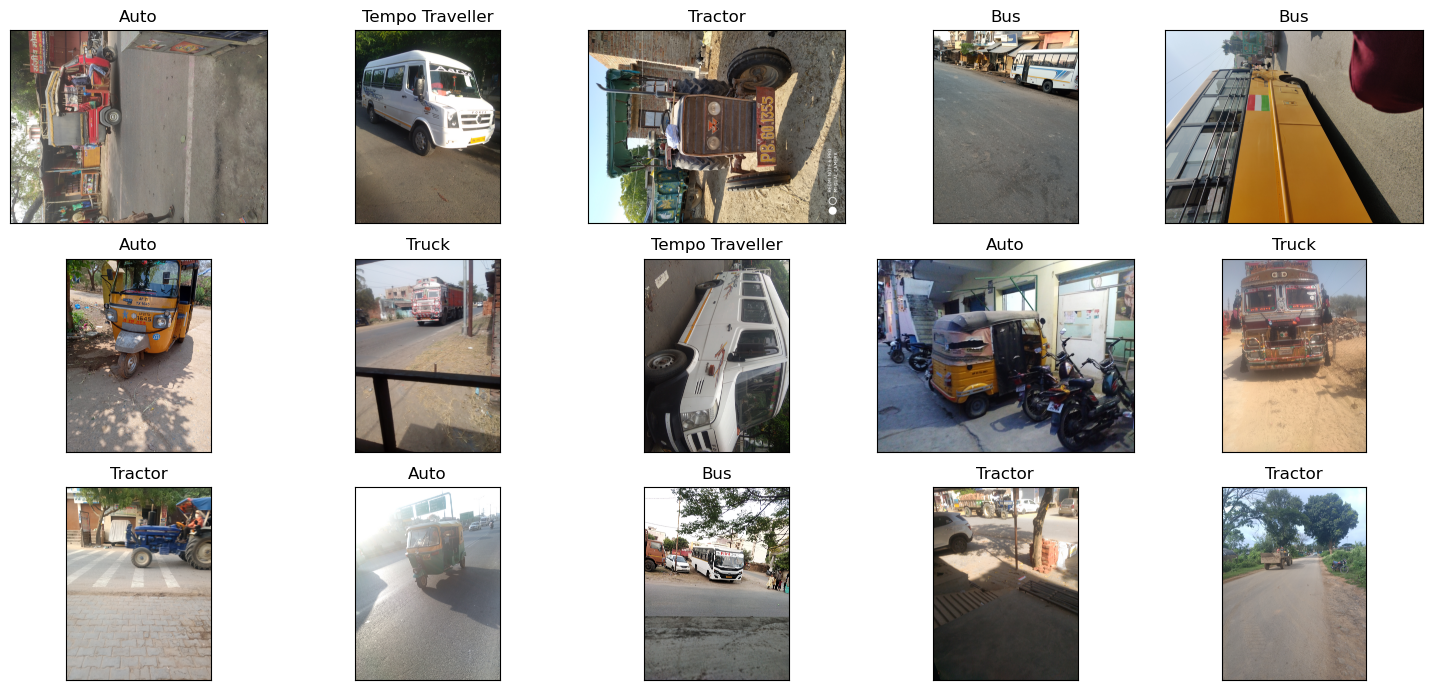

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = plt.imread(im_df['Filepath'][i])
    ax.imshow(img)
    ax.set_title(im_df.Label[i])
plt.tight_layout()
plt.show()

In [52]:
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [115]:
model = Sequential()

# Input layer
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model
model.save('custom_cnn_model.h5')

C:\Users\yahya\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [116]:
from keras.applications.vgg16 import preprocess_input
import cv2
# Define a custom preprocessing function
def custom_preprocess_input(image):
    # Resize the image to a specific size (e.g., 224x224)
    image = cv2.resize(image, (224, 224))
    image = image - [123.68, 116.78, 103.94]  # Mean values for BGR channels
    
    return image

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,           
    rotation_range=20,         
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    horizontal_flip=True,     
    zoom_range=0.2,  
    validation_split = 0.1
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,            
    rotation_range=20,         
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    horizontal_flip=True,     
    zoom_range=0.2            
)

In [117]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 536 validated image filenames belonging to 5 classes.


Found 59 validated image filenames belonging to 5 classes.
Found 149 validated image filenames belonging to 5 classes.


In [118]:
tb_clabacks = tf.keras.callbacks.TensorBoard(log_dir="logs/",histogram_freq=1)
model.fit(train_images, epochs=10, validation_data=val_images,callbacks=[tb_clabacks])

Epoch 1/10
17/17 [==============================] - 74s 4s/step - loss: 2.2521 - accuracy: 0.2034 - val_loss: 1.6038 - val_accuracy: 0.2712
Epoch 2/10
17/17 [==============================] - 65s 4s/step - loss: 1.6062 - accuracy: 0.2295 - val_loss: 1.6091 - val_accuracy: 0.2712
Epoch 3/10
17/17 [==============================] - 59s 3s/step - loss: 1.6038 - accuracy: 0.2369 - val_loss: 1.5949 - val_accuracy: 0.2712
Epoch 4/10
17/17 [==============================] - 58s 3s/step - loss: 1.6124 - accuracy: 0.2537 - val_loss: 1.6076 - val_accuracy: 0.2712
Epoch 5/10
17/17 [==============================] - 58s 3s/step - loss: 1.6070 - accuracy: 0.2556 - val_loss: 1.5964 - val_accuracy: 0.2712
Epoch 6/10
17/17 [==============================] - 57s 3s/step - loss: 1.6056 - accuracy: 0.2575 - val_loss: 1.5892 - val_accuracy: 0.2712
Epoch 7/10
17/17 [==============================] - 58s 3s/step - loss: 1.6015 - accuracy: 0.2575 - val_loss: 1.5947 - val_accuracy: 0.2712
Epoch 8/10
17/17 [==

In [119]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss:",(results[0]))
print("Test Accuracy:",(results[1] * 100),"%")

    Test Loss: 1.6210213899612427
Test Accuracy: 28.187918663024902 %


In [86]:

image_path = "./dataset/Vehicle_5_classes_sample/Tempo Traveller/20210427_07_32_15_000_T4CaxysrQ7W21Wgl1wZWBCtdRjE3_F_3264_2448.jpg"
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224)) 
image = image / 255.0

predictions = model.predict(np.expand_dims(image, axis=0))  # Add a batch dimension
print(predictions)

predicted_class = np.argmax(predictions)

class_labels = ["Auto", "Bus", "Tempo", "Tractor", "Truck"]
predicted_label = class_labels[predicted_class]

print("Predicted Class:", predicted_label)

1/1 [==============================] - 0s 319ms/step
[[0.29067904 0.15425289 0.19268437 0.16815165 0.19423205]]
Predicted Class: Auto


In [106]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
predictions = layers.Dense(5, activation='softmax')(x)  # num_classes is the number of vehicle classes

model = models.Model(inputs=base_model.input, outputs=predictions)

# Fine-tune some top layers
for layer in base_model.layers:
    layer.trainable = False

tb_clabacks = tf.keras.callbacks.TensorBoard(log_dir="logs/",histogram_freq=1)
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using your data generator (train_images)
model.fit(train_images, epochs=10, validation_data=val_images,callbacks=tb_clabacks)

Epoch 1/10
17/17 [==============================] - 75s 4s/step - loss: 1.6303 - accuracy: 0.2612 - val_loss: 1.5925 - val_accuracy: 0.1695
Epoch 2/10
17/17 [==============================] - 68s 4s/step - loss: 1.5689 - accuracy: 0.2668 - val_loss: 1.6080 - val_accuracy: 0.2542
Epoch 3/10
17/17 [==============================] - 72s 4s/step - loss: 1.5109 - accuracy: 0.3302 - val_loss: 1.5103 - val_accuracy: 0.3051
Epoch 4/10
17/17 [==============================] - 75s 4s/step - loss: 1.4865 - accuracy: 0.3358 - val_loss: 1.4462 - val_accuracy: 0.3898
Epoch 5/10
17/17 [==============================] - 72s 4s/step - loss: 1.4417 - accuracy: 0.3993 - val_loss: 1.4198 - val_accuracy: 0.4576
Epoch 6/10
17/17 [==============================] - 72s 4s/step - loss: 1.4013 - accuracy: 0.4291 - val_loss: 1.4504 - val_accuracy: 0.4407
Epoch 7/10
17/17 [==============================] - 72s 4s/step - loss: 1.3862 - accuracy: 0.4347 - val_loss: 1.3376 - val_accuracy: 0.4407
Epoch 8/10
17/17 [==

In [89]:
im_df.sample(10)

,Filepath,Label
10,./dataset/Vehicle_5_classes_sample/Tractor/202...,Tractor
713,./dataset/Vehicle_5_classes_sample/Tractor/202...,Tractor
147,./dataset/Vehicle_5_classes_sample/Tempo Trave...,Tempo Traveller
660,./dataset/Vehicle_5_classes_sample/Truck/Datac...,Truck
206,./dataset/Vehicle_5_classes_sample/Auto/Datacl...,Auto
59,./dataset/Vehicle_5_classes_sample/Tractor/202...,Tractor
123,./dataset/Vehicle_5_classes_sample/Truck/Datac...,Truck
732,./dataset/Vehicle_5_classes_sample/Tractor/202...,Tractor
509,./dataset/Vehicle_5_classes_sample/Tempo Trave...,Tempo Traveller
450,./dataset/Vehicle_5_classes_sample/Auto/Datacl...,Auto


In [87]:
image_path = "./dataset/Vehicle_5_classes_sample/Tempo Traveller/20210427_07_32_15_000_T4CaxysrQ7W21Wgl1wZWBCtdRjE3_F_3264_2448.jpg"


image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224)) 
image = image / 255.0

predictions = model.predict(np.expand_dims(image, axis=0))  # Add a batch dimension
print(predictions)

predicted_class = np.argmax(predictions)

class_labels = ["Auto", "Bus", "Tempo", "Tractor", "Truck"]
predicted_label = class_labels[predicted_class]

print("Predicted Class:", predicted_label)

1/1 [==============================] - 0s 171ms/step
[[0.29067904 0.15425289 0.19268437 0.16815165 0.19423205]]
Predicted Class: Auto


In [81]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss:",(results[0]))
print("Test Accuracy:",(results[1] * 100),"%")

    Test Loss: 1.44214928150177
Test Accuracy: 38.255032896995544 %


In [101]:
import cv2
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image

# Paths to image samples
df = im_df.sample(50)

image_paths = df['Filepath'].to_list()

# True labels from DataFrame
true_labels = df['Label'].tolist()

# List to store predicted probabilities
predicted_probabilities = []

# Make predictions for each image
for image_path in image_paths:
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Predict
    predictions = model.predict(np.expand_dims(image, axis=0))
    
    # Append predicted probabilities
    predicted_probabilities.append(predictions.ravel())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_probabilities = np.array(predicted_probabilities)



1/1 [==============================] - 0s 131ms/step


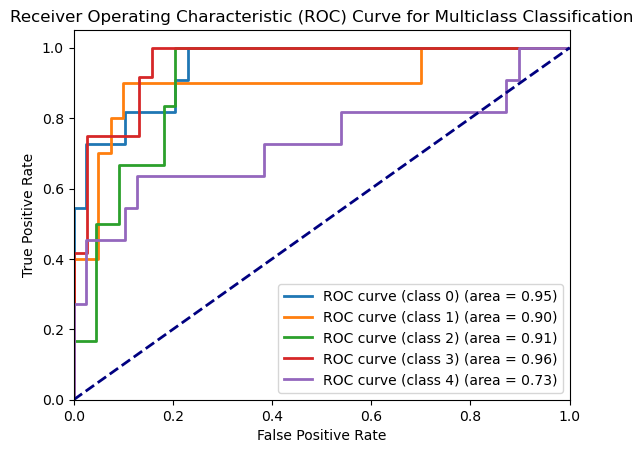

In [104]:
from sklearn.preprocessing import label_binarize
true_labels_bin = label_binarize(true_labels, classes=np.unique(true_labels))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(np.unique(true_labels))):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()

for i in range(len(np.unique(true_labels))):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class {0}) (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()